In [1]:
!python --version

Python 3.8.13


# Extract Time Series Sentinel-2 data
## from Digital Earth Australia (DEA) via STAC

In [10]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import folium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import pystac_client
import odc.stac
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

from datacube.utils.geometry import CRS, Geometry, BoundingBox
from datacube.model import GridSpec

# My helper class
from helperfunctions import begin_timer, end_timer, saveDataset, loadDataset
from dea_helperfunctions import DEA_HelperFunctions

from dea_tools.plotting import rgb, map_shapefile

### Constants

In [11]:
# Coordinate Reference Systems (CRS)
# !! ENSURE YOU USING CONSISTENT CRS WHEN PLOTTING AREAS OR PERFORMING GEOMETRIC OPERATIONS.
epsg4326 = 'epsg:4326'            # EPSG:4326 | WGS84 latitude-longitude CRS | in Degrees of Latitude and Longitude
epsg3577 = 'epsg:3577'            # EPSG:3577 | GDA94 / Australian Albers projection | in Metres from CRS Centroid

cropregions_geojsonfile = '../datasets/crop_regions.json'

# configure helper functions
dea_fns = DEA_HelperFunctions()
basepath = "../datasets/Sentinel2withIndices_"
fileextn = ".pkl"

filespecifier = "PortGawlerBeachSA_2022_Mar_10x5_"

### Extract and plot Survey area tiles

In [12]:
#Extract GeoDataFrame containing polygons
gdf_surveyarea = loadDataset(basepath + filespecifier + "_tilepolygons" + fileextn)
print(gdf_surveyarea.crs)
gdf_surveyarea.head(5)

epsg:3577


,tile,geometry
0,1,"POLYGON ((587352.715 -3795648.621, 587610.746 ..."
1,2,"POLYGON ((592458.349 -3795907.007, 592718.624 ..."
2,3,"POLYGON ((597563.870 -3796167.629, 597826.388 ..."
3,4,"POLYGON ((602669.277 -3796430.487, 602934.037 ..."
4,5,"POLYGON ((607774.568 -3796695.581, 608041.570 ..."


In [13]:
map_centroid = [-34.62929501472954, 138.43196647747274] # PortGawlerBeach, SA
map_zoom_level = 8

m = gdf_surveyarea.explore( 
     column="tile", # make choropleth based on Commodity description
     tooltip=["tile"],
     popup=True, # show all values in popup (on click)
     tiles="OpenStreetMap", # use "CartoDB positron" tiles
     cmap="Wistia", # use "Set1" matplotlib colormap
     legend=False,
     location=map_centroid,
     zoom_start = map_zoom_level,
     name='Survey Area Tiles' )

folium.TileLayer('CartoDB positron', control=True).add_to(m)  # use folium to add alternative tiles
folium.LayerControl().add_to(m)  # use folium to add layer control
m  # show map

### Extract and display images from Survey area dataset

In [14]:
surveyarea_ds = [] # [timeband, tile number, polygon, dataset]
surveyarea_ds = loadDataset(basepath + filespecifier + fileextn)

In [15]:
surveyarea_filter = filter(lambda ds: (ds[1] == 2022)  # Year
                                    #& (ds[2] == 3),  # Month
                                    & (ds[4] == 1), # Tile
                                  surveyarea_ds)

surveyarea_tiles = list(surveyarea_filter)
surveyarea_tiles[0]

[['2022-03-01', '2022-03-05'],
 2022,
 3,
 2,
 1,
 BoundingBox(left=587352.7147204994, bottom=-3795907.0067901625, right=592718.6237392412, top=-3790527.7704707165),
 <xarray.Dataset>
 Dimensions:      (time: 2, y: 512, x: 512)
 Coordinates:
   * time         (time) datetime64[ns] 2022-03-02T00:46:52.624724 2022-03-05T...
   * y            (y) float64 -3.796e+06 -3.796e+06 ... -3.801e+06 -3.801e+06
   * x            (x) float64 5.874e+05 5.874e+05 ... 5.925e+05 5.925e+05
     spatial_ref  int32 3577
 Data variables:
     nbart_blue   (time, y, x) uint16 249 255 251 281 295 ... 693 627 710 565 368
     nbart_green  (time, y, x) uint16 309 327 321 352 367 ... 809 790 848 655 416
     nbart_red    (time, y, x) uint16 360 370 381 401 431 ... 936 946 986 738 429
     nbart_nir_1  (time, y, x) uint16 1609 1560 1642 1717 ... 1466 1460 1062 515
     NDVI         (time, y, x) float64 0.6343 0.6166 0.6233 ... 0.18 0.0911
     kNDVI        (time, y, x) float64 0.382 0.3629 0.3701 ... 0.03239 0.00

### Plot NIR and Additional Band Indices

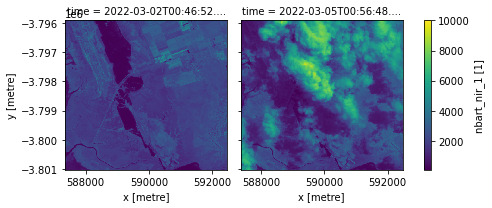

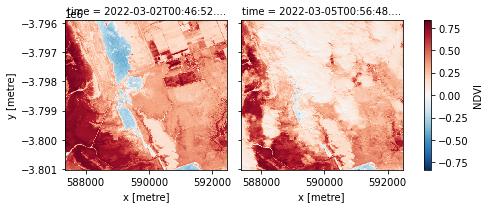

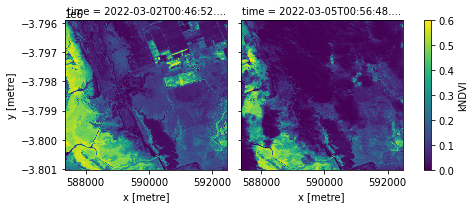

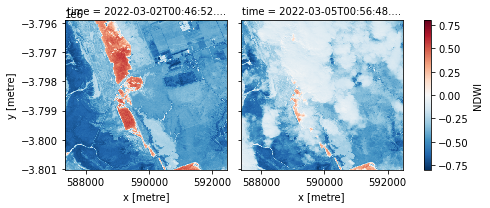

In [16]:
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    
    ds.nbart_nir_1.plot.imshow(col="time")
    ds.NDVI.plot.imshow(col="time")
    ds.kNDVI.plot.imshow(col="time")
    ds.NDWI.plot.imshow(col="time")

## Plot RGB

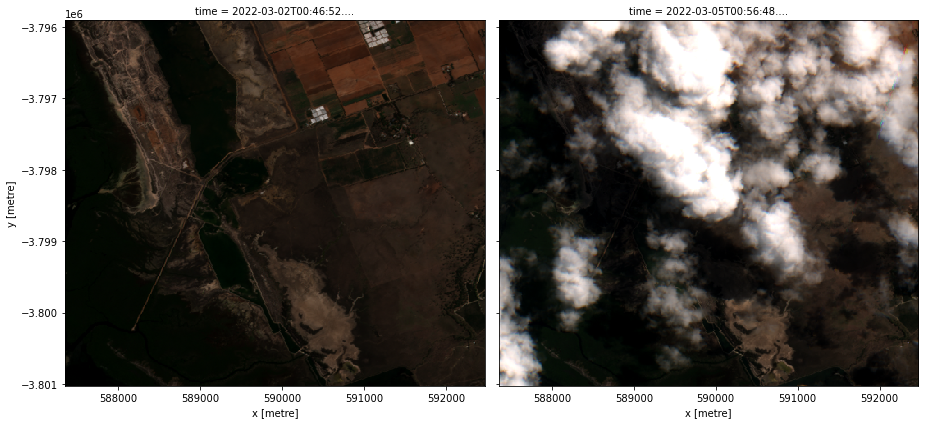

In [9]:
for surveyarea_tile in surveyarea_tiles:
    ds = surveyarea_tile[6] # extract xarray
    rgb(ds, bands=['nbart_red', 'nbart_green', 'nbart_blue'], col="time")